### Import Necessary Packages

In [24]:
import sys
import time
import dotenv
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold

In [ ]:
sys.path.append("../..")
from src.algorithms.multi_objective.MOEA_D_AM import MOEA_D_ACO

### Loading TicTacToe Dataset

In [3]:
env = dotenv.find_dotenv()
df = pd.read_csv(dotenv.get_key(env, 'DATA_DIR'))

X = df.drop('class', axis=1)
y = df['class'].astype(str)

### Define Args

In [26]:
args = {
    'population': 20,
    'neighbors': 5,
    'groups': 2,
    'min_examples': 10,
    'max_uncovered': 10,
    'max_iter': 100,
    'p': 0.9,
    'gamma': 0.9,
    'delta': 0.5,
    'alpha': 1,
    'beta': 1,
    'pruning': 0
}

### Stratified Cross Validation

In [27]:
sets = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [28]:
def cross_validation(X, y, sets, args):

    results = pd.DataFrame(columns=['fold', 'time', 'accuracy', 'f1_score', 'rules'])
    archive = []

    print(f"Running cross-validation with {sets.n_splits} folds...")
    for i, (train_index, test_index) in enumerate(sets.split(X, y)):

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
        moea_d_aco = MOEA_D_ACO(
            population=args['population'],
            neighbors=args['neighbors'],
            groups=args['groups'],
            min_examples=args['min_examples'],
            max_uncovered=args['max_uncovered'],
            max_iter=args['max_iter'],
            p=args['p'],
            gamma=args['gamma'],
            delta=args['delta'],
            alpha=args['alpha'],
            beta=args['beta'],
            pruning=args['pruning']
        )

        start_time = time.time()
        moea_d_aco.run(X_train, y_train)
        end_time = time.time()

        elapsed_time = end_time - start_time
    
        # Evaluate the model on the test set
        accuracy, f1_score = moea_d_aco.evaluate(X_test, y_test)

        results.loc[i] = [i + 1, elapsed_time, accuracy*100, f1_score*100, len(moea_d_aco.ARCHIVE)]

        archive.append(moea_d_aco.ARCHIVE)

    print("Cross-validation completed.")
    return results, archive

### Training

In [7]:
results, archive = cross_validation(X, y, sets, args)

Running cross-validation with 10 folds...


Running MOEA/D-ACO: 100%|██████████| 100/100 [00:20<00:00,  4.85it/s]

Cross-validation completed.


### Results

In [36]:
results

,fold,time,accuracy,f1_score,rules
0,1.0,5.208766,71.875000,71.532392,10.0
1,2.0,2.438026,62.500000,59.963768,10.0
2,3.0,22.896045,67.708333,66.642507,14.0
3,4.0,110.790026,79.166667,77.757649,12.0
4,5.0,4.698125,67.708333,68.376437,8.0
5,6.0,7.889097,75.000000,71.277546,10.0
6,7.0,25.188178,62.500000,63.066880,13.0
7,8.0,39.671265,66.666667,65.454545,11.0
8,9.0,20.895112,69.473684,68.096557,10.0
9,10.0,21.349192,63.157895,61.495845,11.0


In [15]:
print(f"Average Accuracy: {results['accuracy'].mean():.2f}% ± {results['accuracy'].std():.2f}%")
print(f"Average F1 Score: {results['f1_score'].mean():.2f}% ± {results['f1_score'].std():.2f}%")
print(f"Average Rules: {results['rules'].mean():.2f} ± {results['rules'].std():.2f}")
print(f"Average Time: {results['time'].mean():.2f}s ")

Average Accuracy: 68.58% ± 5.51%
Average F1 Score: 67.37% ± 5.31%
Average Rules: 10.90 ± 1.73
Average Time: 26.10s 


### Patero Front Plots

In [36]:
def plot_pareto_fronts(archives: list, folds: int = 10) -> None:

    if not archives or any(len(archive) == 0 for archive in archives):
        raise ValueError("At least one of the archives is empty. Cannot plot Pareto fronts.")

    sns.set(style="whitegrid")
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.flatten()

    for i in range(folds):
        archive = archives[i]
        fitness_values = np.array([ant['fitness'] for ant in archive])

        ax = axes[i]
        ax.scatter(
            fitness_values[:, 0], 
            fitness_values[:, 1],
            c='dodgerblue',
            edgecolors='black',
            s=60,
            alpha=0.8
        )
        ax.set_title(f'Fold {i+1}', fontsize=12)
        ax.set_xlabel('Sensitivity')
        ax.set_ylabel('Specificity')
        ax.grid(True, linestyle='--', alpha=0.6)

    # Hide unused axes if any
    for j in range(folds, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle('MOEA/D-AM: Pareto Fronts Across 10 for TicTacToe Dataset', fontsize=18)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

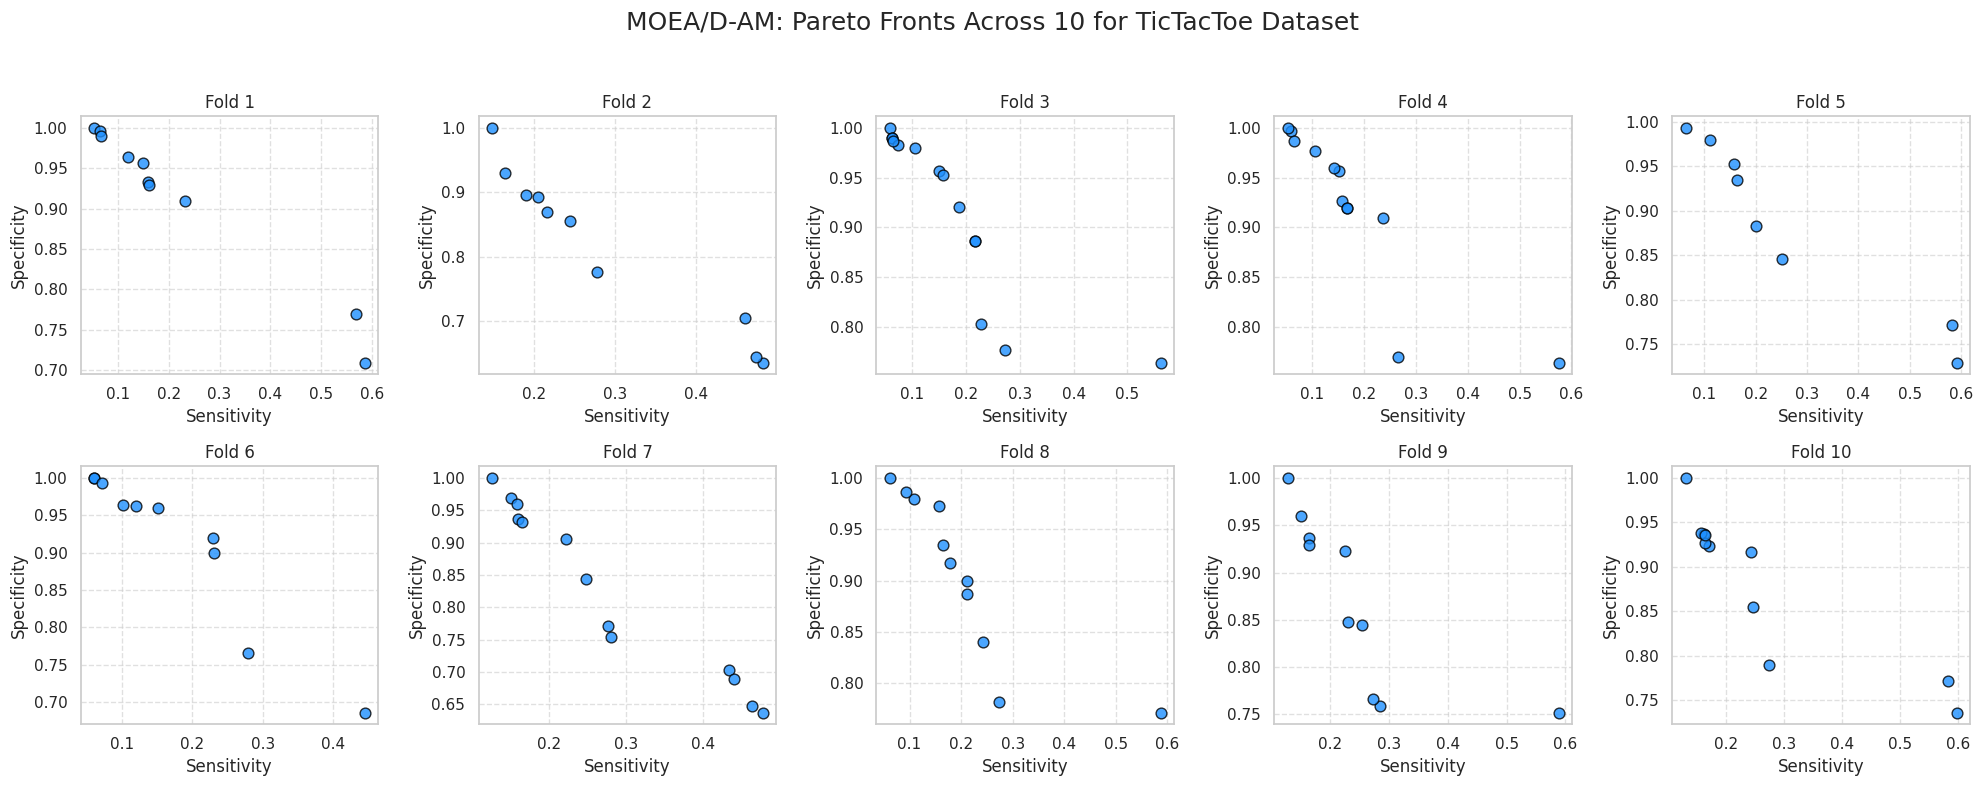

In [17]:
plot_pareto_fronts(archive, 10)

In [47]:
def plot_pareto_front(archives: list, folds: int = 10) -> None:

    if not archives or any(len(archive) == 0 for archive in archives):
        raise ValueError("At least one of the archives is empty. Cannot plot Pareto fronts.")

    # Set modern style
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 8))

    colors = sns.color_palette("husl", n_colors=folds)

    for i in range(folds):
        archive = archives[i]
        fitness_values = np.array([ant['fitness'] for ant in archive])
        plt.scatter(
            fitness_values[:, 0], 
            fitness_values[:, 1], 
            label=f'Fold {i+1}',
            s=60,
            color=colors[i],
            edgecolor='black',
            alpha=0.8
        )

    plt.title('MOEA/D-AM: Pareto Fronts Across 10 folds for TicTacToe Dataset', fontsize=16)
    plt.xlabel('Sensitivity', fontsize=14)
    plt.ylabel('Specificity', fontsize=14)
    plt.legend(title="Folds")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

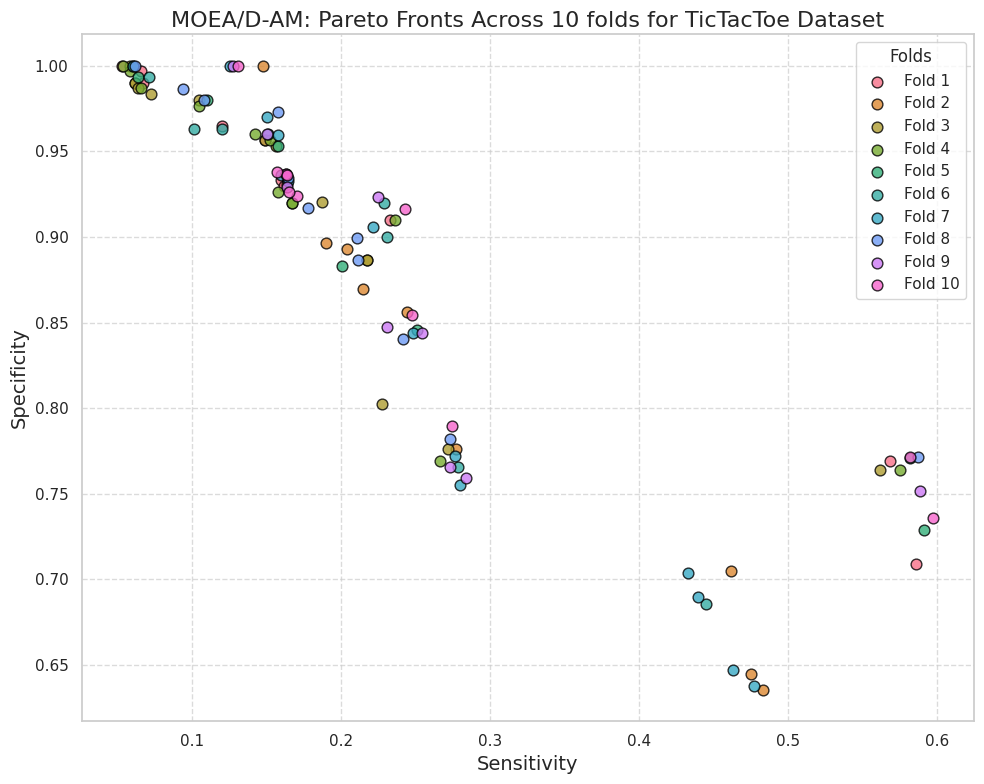

In [19]:
plot_pareto_front(archive, folds=10)

In [22]:
def run_multiple_times(X, y, sets, args, runs=10):

    all_results = pd.DataFrame(columns=['fold', 'time', 'accuracy', 'f1_score', 'rules'])
    all_archives = []

    for run in range(runs):
        print(f"Run {run + 1}/{runs}")
        results, archive = cross_validation(X, y, sets, args)
        all_results = pd.concat([all_results, results], ignore_index=True)
        all_archives.append(archive)

    print("All runs completed.")
    return all_results, all_archives

In [24]:
all_results, all_archives = run_multiple_times(X, y, sets, args, runs=10)

Run 1/10
Running cross-validation with 10 folds...


Running MOEA/D-ACO:  23%|██▎       | 23/100 [00:05<00:17,  4.29it/s]
/tmp/ipykernel_98969/252654097.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_results = pd.concat([all_results, results], ignore_index=True)


Cross-validation completed.
Run 2/10
Running cross-validation with 10 folds...


Running MOEA/D-ACO: 100%|██████████| 100/100 [00:28<00:00,  3.53it/s]


Cross-validation completed.
Run 3/10
Running cross-validation with 10 folds...


Running MOEA/D-ACO: 100%|██████████| 100/100 [00:22<00:00,  4.44it/s]


Cross-validation completed.
Run 4/10
Running cross-validation with 10 folds...


Running MOEA/D-ACO: 100%|██████████| 100/100 [00:13<00:00,  7.34it/s]


Cross-validation completed.
Run 5/10
Running cross-validation with 10 folds...


Running MOEA/D-ACO:  15%|█▌        | 15/100 [00:04<00:28,  3.01it/s]


Cross-validation completed.
Run 6/10
Running cross-validation with 10 folds...


Running MOEA/D-ACO: 100%|██████████| 100/100 [00:25<00:00,  3.85it/s]


Cross-validation completed.
Run 7/10
Running cross-validation with 10 folds...


Running MOEA/D-ACO:  16%|█▌        | 16/100 [00:05<00:29,  2.87it/s]


Cross-validation completed.
Run 8/10
Running cross-validation with 10 folds...


Running MOEA/D-ACO: 100%|██████████| 100/100 [00:18<00:00,  5.37it/s]


Cross-validation completed.
Run 9/10
Running cross-validation with 10 folds...


Running MOEA/D-ACO: 100%|██████████| 100/100 [00:19<00:00,  5.00it/s]


Cross-validation completed.
Run 10/10
Running cross-validation with 10 folds...


Running MOEA/D-ACO: 100%|██████████| 100/100 [00:14<00:00,  7.05it/s]

Cross-validation completed.
All runs completed.


In [31]:
def plot_all_pareto_fronts(all_archives):
    """
    Plot all Pareto points (sensitivity vs specificity) from all runs and folds.
    - Single color
    - No legend
    - No lines
    """

    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 8))

    for run_archives in all_archives:
        for archive in run_archives:
            if not archive:
                continue
            fitness_values = np.array([ant['fitness'] for ant in archive])
            
            # Plot points only
            plt.scatter(
                fitness_values[:, 0], 
                fitness_values[:, 1], 
                s=25, 
                color='dodgerblue', 
                alpha=0.7,
                edgecolors='black',
                linewidth=0.3
            )

    plt.title("Pareto Points Across All Runs and Folds", fontsize=16)
    plt.xlabel("Sensitivity", fontsize=14)
    plt.ylabel("Specificity", fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

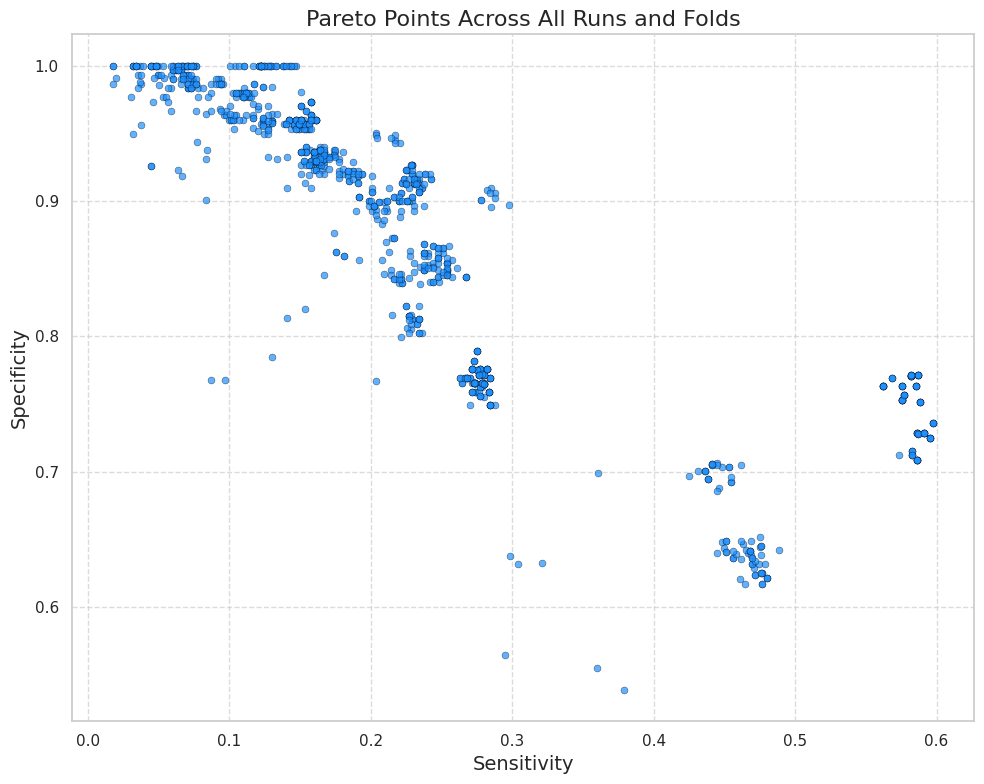

In [32]:
plot_all_pareto_fronts(all_archives)

In [34]:
# results
print(f"Average Accuracy: {all_results['accuracy'].mean():.2f}% ± {all_results['accuracy'].std():.2f}%")
print(f"Average F1 Score: {all_results['f1_score'].mean():.2f}% ± {all_results['f1_score'].std():.2f}%")
print(f"Average Rules: {all_results['rules'].mean():.2f} ± {all_results['rules'].std():.2f}")
print(f"Average Time: {all_results['time'].mean():.2f}s ± {all_results['time'].std():.2f}s")

Average Accuracy: 66.89% ± 5.38%
Average F1 Score: 64.90% ± 6.27%
Average Rules: 10.08 ± 3.00
Average Time: 19.12s ± 19.41s


### Loading Ljubljana Dataset

In [29]:
df = pd.read_csv('/home/adel/Documents/Code/Ant-Miner/datasets/ljubljana.csv')

X = df.drop('class', axis=1)
y = df['class'].astype(str)
df['deg-malig'] = df['deg-malig'].astype(str)
df['irradiat'] = df['irradiat'].astype(str)

In [32]:
# handling missing values with mode
X['falsede-caps'] = X['falsede-caps'].fillna(X['falsede-caps'].mode()[0])
X['breast-quad'] = X['breast-quad'].fillna(X['breast-quad'].mode()[0])

/tmp/ipykernel_5117/1797399104.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X['falsede-caps'] = X['falsede-caps'].fillna(X['falsede-caps'].mode()[0])


In [39]:
results, archive = cross_validation(X, y, sets, args)

Running cross-validation with 10 folds...


Running MOEA/D-ACO: 100%|██████████| 100/100 [00:21<00:00,  4.73it/s]

Cross-validation completed.


In [42]:
results

,fold,time,accuracy,f1_score,rules
0,1.0,18.247149,60.714286,58.222997,6.0
1,2.0,15.812343,67.857143,68.390433,9.0
2,3.0,0.794323,55.555556,57.037037,7.0
3,4.0,1.015854,74.074074,75.009747,10.0
4,5.0,0.799762,37.037037,37.037037,6.0
5,6.0,0.808765,37.037037,27.769761,7.0
6,7.0,0.714014,74.074074,69.689139,9.0
7,8.0,12.822440,77.777778,75.132275,7.0
8,9.0,0.798630,70.370370,70.370370,8.0
9,10.0,21.583189,77.777778,75.132275,8.0


In [44]:
print(f"Average Accuracy: {results['accuracy'].mean():.2f}% ± {results['accuracy'].std():.2f}%")
print(f"Average F1 Score: {results['f1_score'].mean():.2f}% ± {results['f1_score'].std():.2f}%")
print(f"Average Rules: {results['rules'].mean():.2f} ± {results['rules'].std():.2f}")
print(f"Average Time: {results['time'].mean():.2f}s ")

Average Accuracy: 63.23% ± 15.52%
Average F1 Score: 61.38% ± 16.71%
Average Rules: 7.70 ± 1.34
Average Time: 7.34s 


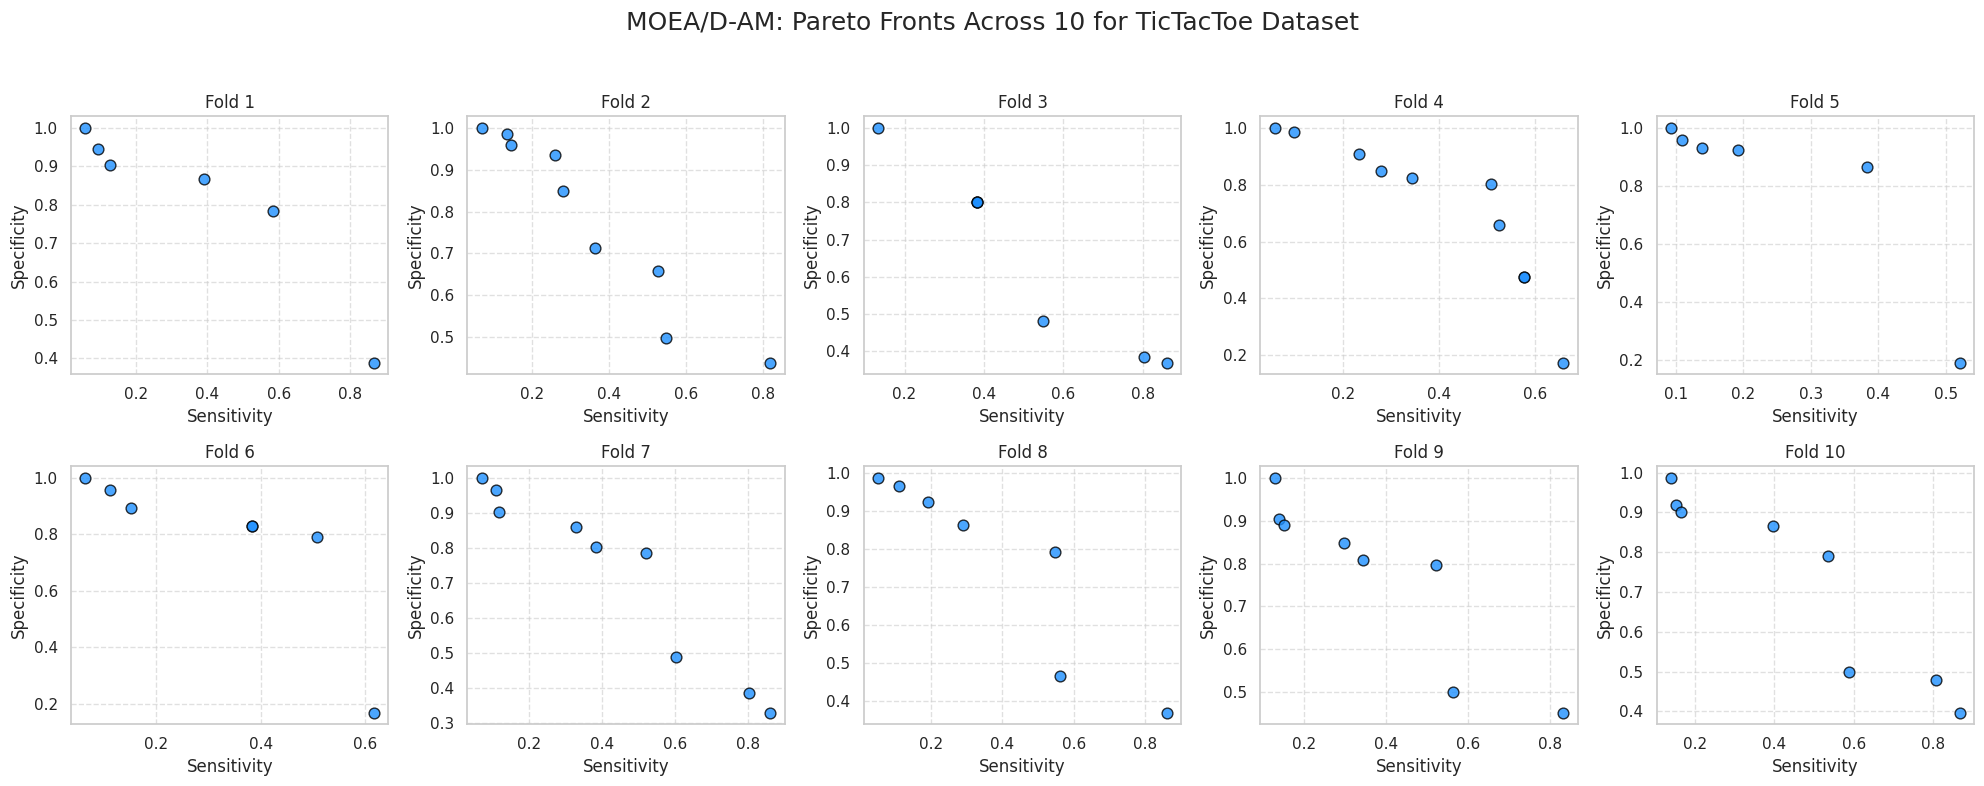

In [45]:
plot_pareto_fronts(archive, 10)

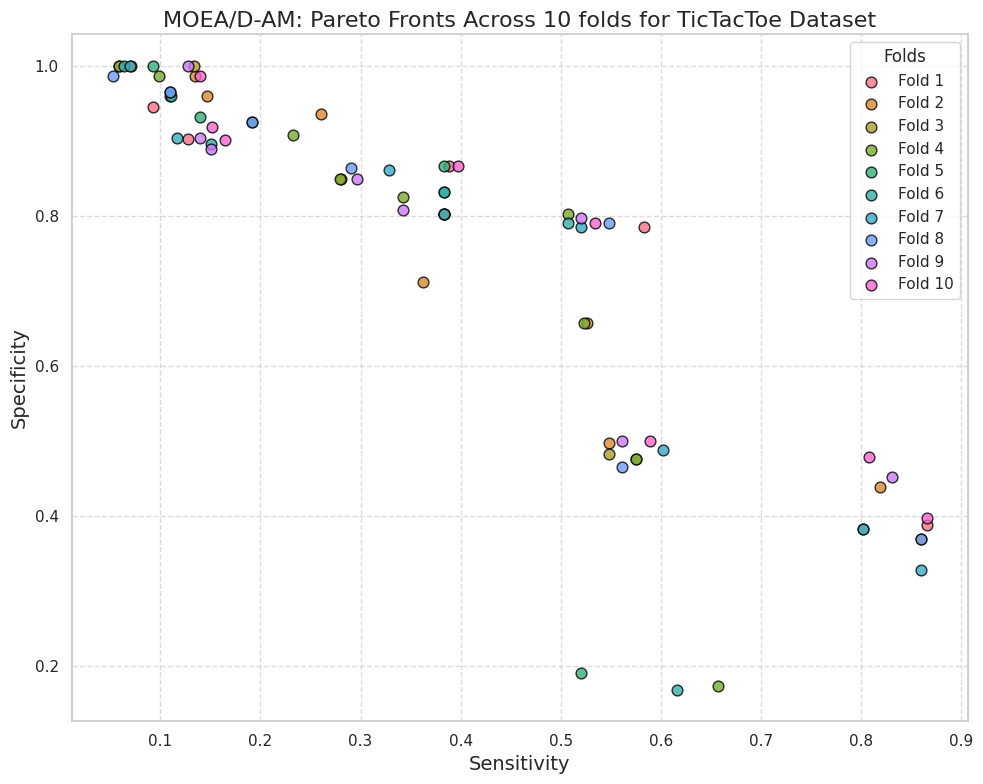

In [48]:
plot_pareto_front(archive, folds=10)